In [2]:
#Project Header and Imports
"""
DenseNet-121 Baseline Model for NIH Chest X-ray Classification
COSC 4368 Final Project - Group 13
Yla Herrera, Nicolas Mangilit, Kiriti Padavala, and Matt Tindall
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm

print("All libraries imported successfully!")

Matplotlib is building the font cache; this may take a moment.


All libraries imported successfully!


In [3]:
# Set Random Seeds and Check Device
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# heck for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [3]:
# Cell 3: Define Paths and Load Metadata
DATA_DIR = "data" 

# The dataset has images split across multiple folders: images_001 to images_012

#Load metadata
print("Loading metadata CSV...")
csv_path = os.path.join(DATA_DIR, "Data_Entry_2017.csv")
df = pd.read_csv(csv_path)

print(f"✓ Total number of images: {len(df)}")
print(f"\nDataset columns:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
print(df.head())

#Look at image folders
print(f"\nChecking for image folders...")
image_folders = []
for i in range(1, 13):  #all folders
    folder_name = f"images_{i:03d}"
    folder_path = os.path.join(DATA_DIR, folder_name)
    if os.path.exists(folder_path):
        num_images = len([f for f in os.listdir(folder_path) if f.endswith('.png')])
        image_folders.append(folder_name)
        print(f"Found {folder_name} with {num_images} images")

print(f"\nTotal image folders found: {len(image_folders)}")


Loading metadata CSV...
✓ Total number of images: 112120

Dataset columns:
['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']

First few rows:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA  

In [4]:
#Define Disease Categories
# The 14 disease categories in NIH Chest X-ray dataset
DISEASE_CATEGORIES = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Pleural_Thickening', 'Hernia'
]

print(f"Number of disease categories: {len(DISEASE_CATEGORIES)}")
print(f"Disease categories: {DISEASE_CATEGORIES}")

Number of disease categories: 14
Disease categories: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']



Disease distribution:
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64


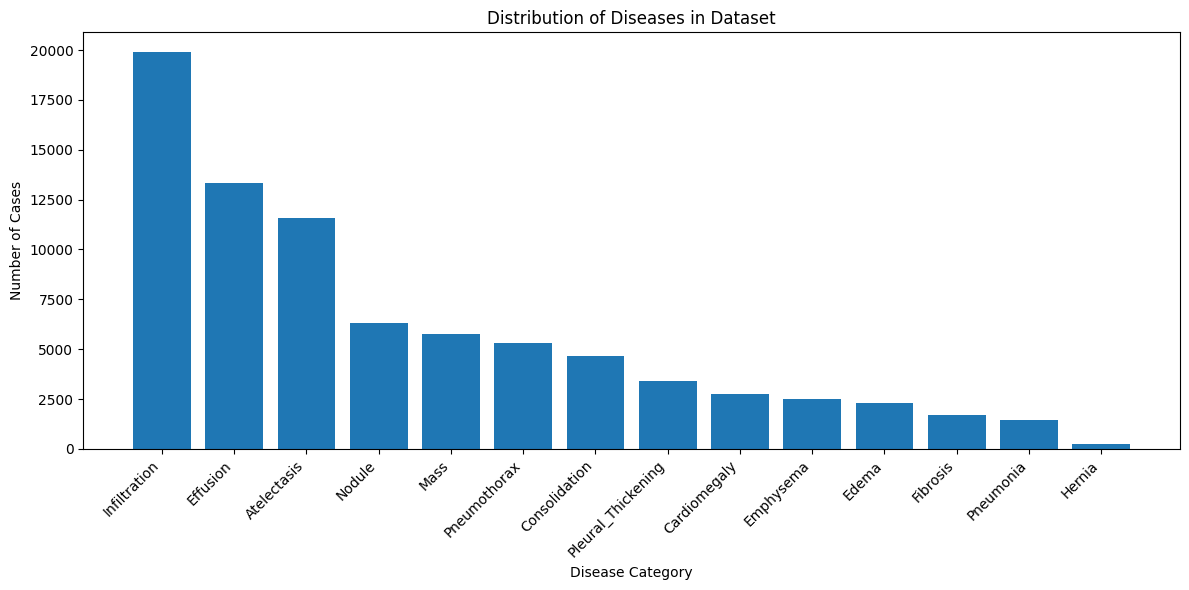

In [5]:
# Parse Labels and Create Binary Columns
# Parse labels (Finding Labels column contains multiple labels separated by |)
def parse_labels(label_string, disease_categories):
    """Convert label string to multi-hot encoded vector"""
    labels = np.zeros(len(disease_categories))
    if label_string != "No Finding":
        diseases = label_string.split('|')
        for disease in diseases:
            if disease in disease_categories:
                idx = disease_categories.index(disease)
                labels[idx] = 1
    return labels

# Add binary labels for each disease
for disease in DISEASE_CATEGORIES:
    df[disease] = df['Finding Labels'].apply(
        lambda x: 1 if disease in x else 0
    )

print(f"\nDisease distribution:")
print(df[DISEASE_CATEGORIES].sum().sort_values(ascending=False))

# Visualize disease distribution
plt.figure(figsize=(12, 6))
disease_counts = df[DISEASE_CATEGORIES].sum().sort_values(ascending=False)
plt.bar(range(len(disease_counts)), disease_counts.values)
plt.xticks(range(len(disease_counts)), disease_counts.index, rotation=45, ha='right')
plt.xlabel('Disease Category')
plt.ylabel('Number of Cases')
plt.title('Distribution of Diseases in Dataset')
plt.tight_layout()
plt.show()

In [6]:
class ChestXrayDataset(Dataset):
    """Custom Dataset for NIH Chest X-rays

    image_dir may be a single path (string) or a list/tuple of directories.
    If multiple directories are provided, __getitem__ will search them in order
    for the requested image filename.
    """

    def __init__(self, dataframe, image_dir, disease_categories, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        # allow a single path or multiple roots
        if isinstance(image_dir, (list, tuple)):
            self.image_dirs = list(image_dir)
        else:
            self.image_dirs = [image_dir]

        # keep original for compatibility
        self.image_dir = image_dir
        self.disease_categories = disease_categories
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image filename
        img_name = self.dataframe.loc[idx, 'Image Index']

        # Try each candidate root until file is found
        img_path = None
        for root in self.image_dirs:
            candidate = os.path.join(root, img_name)
            if os.path.exists(candidate):
                img_path = candidate
                break

        if img_path is None:
            # helpful message showing where we looked
            raise FileNotFoundError(f"Image '{img_name}' not found in any of: {self.image_dirs}")

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Get labels (multi-hot encoded)
        labels = self.dataframe.loc[idx, self.disease_categories].values.astype(np.float32)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels)

In [ ]:
# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

print("Data transforms defined:")
print(f"  - Train: Resize(224x224), RandomHorizontalFlip, ToTensor, Normalize")
print(f"  - Val: Resize(224x224), ToTensor, Normalize")

Data transforms defined:
  - Train: Resize(224x224), RandomHorizontalFlip, ToTensor, Normalize
  - Val: Resize(224x224), ToTensor, Normalize


In [ ]:
# Train/Validation Split
# Simple train/validation split (80/20)
# For your project, you may want to use the official NIH train/val/test split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.sample(n=8000, random_state=42)
val_df = val_df.sample(n=2000, random_state=42)
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"\nTrain/Val split ratio: {len(train_df)/len(df):.2%} / {len(val_df)/len(df):.2%}")

Train set size: 8000
Validation set size: 2000

Train/Val split ratio: 7.14% / 1.78%


In [ ]:
# Create datasets
DATA_DIR = "data"

# The images are split across multiple folders images_001..images_012 (each contains an inner 'images' folder).
# Build a list of directories to search for files and pass that to the dataset so it can locate each image.
IMAGE_DIRS = [os.path.join(DATA_DIR, f"images_{i:03d}", "images") for i in range(1, 13)]
# keep only existing directories (helps if some folders are missing locally)
IMAGE_DIRS = [p for p in IMAGE_DIRS if os.path.exists(p)]
print(f"Found {len(IMAGE_DIRS)} image directories; using:\n  - " + "\n  - ".join(IMAGE_DIRS))

train_dataset = ChestXrayDataset(
    train_df, 
    IMAGE_DIRS, 
    DISEASE_CATEGORIES, 
    transform=train_transform
)

val_dataset = ChestXrayDataset(
    val_df, 
    IMAGE_DIRS, 
    DISEASE_CATEGORIES, 
    transform=val_transform,
)

# Create dataloaders
# Use a smaller batch size on CPU and avoid worker processes on Windows (spawn overhead can be very slow)
BATCH_SIZE = 8  # Reduce for CPU (increase if you have more RAM/CPU)
if os.name == 'nt':
    NUM_WORKERS = 0
else:
    NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
)

print(f"DataLoaders created:")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Val batches: {len(val_loader)}")
print(f"  - Num workers: {NUM_WORKERS}")

Found 12 image directories; using:
  - data\images_001\images
  - data\images_002\images
  - data\images_003\images
  - data\images_004\images
  - data\images_005\images
  - data\images_006\images
  - data\images_007\images
  - data\images_008\images
  - data\images_009\images
  - data\images_010\images
  - data\images_011\images
  - data\images_012\images
DataLoaders created:
  - Batch size: 8
  - Train batches: 1000
  - Val batches: 250
  - Num workers: 0


In [10]:
# Diagnostic & Quick Debug Training (CPU-friendly)
# Measures DataLoader load/transfer times and runs a short 1-epoch training on a small subset
import time
from torch.utils.data import Subset

print('Device:', device)
print('Train dataset length:', len(train_dataset))
print('Train loader batches:', len(train_loader))
print('Batch size:', BATCH_SIZE, 'Num workers:', NUM_WORKERS)

# Ensure a model is available on CPU for the debug run
if 'model' not in globals():
    print("`model` not found — initializing DenseNet121 (pretrained=False) for debug.")
    try:
        model = DenseNet121(num_classes=len(DISEASE_CATEGORIES), pretrained=False)
    except NameError:
        print("`DenseNet121` class not found — building model directly from torchvision.models")
        base = models.densenet121(pretrained=False)
        num_features = base.classifier.in_features
        base.classifier = nn.Linear(num_features, len(DISEASE_CATEGORIES))
        model = base

# Move model to CPU for this debug run
model = model.to('cpu')

# Ensure a loss function exists
if 'criterion' not in globals():
    criterion = nn.BCEWithLogitsLoss()

# Use a small subset for a quick smoke test
DEBUG_SAMPLES = min(200, len(train_dataset))
subset_idx = list(range(DEBUG_SAMPLES))
debug_loader = DataLoader(Subset(train_dataset, subset_idx), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Measure first few batches (load + forward+loss computation)
load_times = []
step_times = []

it = iter(debug_loader)
for i in range(min(5, len(debug_loader))):
    t0 = time.time()
    imgs, lbls = next(it)
    t1 = time.time()
    load_times.append(t1 - t0)

    t2 = time.time()
    # ensure tensors on CPU (this notebook runs on CPU)
    outputs = model(imgs)
    loss = criterion(outputs, lbls)
    t3 = time.time()
    step_times.append(t3 - t2)
    print(f"Batch {i+1}: load={load_times[-1]:.3f}s, forward+loss={step_times[-1]:.3f}s")

if load_times:
    print(f"Avg load time: {sum(load_times)/len(load_times):.3f}s, avg forward+loss: {sum(step_times)/len(step_times):.3f}s")

# Quick 1-epoch training on the small subset (use CPU)
print('\nStarting short debug training (1 epoch over {} samples)'.format(DEBUG_SAMPLES))
optimizer_debug = optim.Adam(model.parameters(), lr=1e-4)

model.train()
start = time.time()
for i, (imgs, lbls) in enumerate(debug_loader, 1):
    t0 = time.time()
    optimizer_debug.zero_grad()
    outputs = model(imgs)
    loss = criterion(outputs, lbls)
    loss.backward()
    optimizer_debug.step()
    t1 = time.time()
    if i % 10 == 0 or i == len(debug_loader):
        print(f"Step {i}/{len(debug_loader)} - loss={loss.item():.4f} step_time={t1-t0:.3f}s")
end = time.time()
print(f"Debug epoch complete in {end - start:.1f}s")


Device: cpu
Train dataset length: 8000
Train loader batches: 1000
Batch size: 8 Num workers: 0
`model` not found — initializing DenseNet121 (pretrained=False) for debug.
`DenseNet121` class not found — building model directly from torchvision.models


c:\Users\Nico Mangilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nico Mangilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Batch 1: load=0.458s, forward+loss=0.790s
Batch 2: load=0.349s, forward+loss=0.768s
Batch 3: load=0.333s, forward+loss=0.548s
Batch 4: load=0.357s, forward+loss=0.925s
Batch 5: load=0.446s, forward+loss=1.092s
Avg load time: 0.389s, avg forward+loss: 0.825s

Starting short debug training (1 epoch over 200 samples)
Step 10/25 - loss=0.5881 step_time=2.728s
Step 20/25 - loss=0.4423 step_time=1.865s
Step 25/25 - loss=0.3844 step_time=1.748s
Debug epoch complete in 70.2s


In [11]:
# Quick smoke-check: verify datasets & that an example image file exists
print('IMAGE_DIRS:', IMAGE_DIRS)
print('Train dataset length:', len(train_dataset))
print('Val dataset length:', len(val_dataset))

# Small helper to locate a filename inside the configured roots
from pathlib import Path

def find_image_path(image_name, search_dirs):
    for d in search_dirs:
        candidate = os.path.join(d, image_name)
        if os.path.exists(candidate):
            return candidate
    return None

sample_name = train_df.iloc[0]['Image Index']
print('Sample image name (from train_df):', sample_name)
found = find_image_path(sample_name, IMAGE_DIRS)
print('Found sample path:' , found)

IMAGE_DIRS: ['data\\images_001\\images', 'data\\images_002\\images', 'data\\images_003\\images', 'data\\images_004\\images', 'data\\images_005\\images', 'data\\images_006\\images', 'data\\images_007\\images', 'data\\images_008\\images', 'data\\images_009\\images', 'data\\images_010\\images', 'data\\images_011\\images', 'data\\images_012\\images']
Train dataset length: 8000
Val dataset length: 2000
Sample image name (from train_df): 00005750_025.png
Found sample path: data\images_003\images\00005750_025.png


In [ ]:
# Define DenseNet-121 Model
class DenseNet121(nn.Module):
    """DenseNet-121 for multi-label chest X-ray classification"""
    
    def __init__(self, num_classes=14, pretrained=True):
        super(DenseNet121, self).__init__()
        
        # Load pre-trained DenseNet-121
        self.densenet = models.densenet121(pretrained=pretrained)
        
        # Get number of input features for the classifier
        num_features = self.densenet.classifier.in_features
        
        # Replace the classifier for multi-label classification
        self.densenet.classifier = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.densenet(x)

print("DenseNet121 model class defined!")

DenseNet121 model class defined!


In [ ]:

# Initialize model
model = DenseNet121(num_classes=len(DISEASE_CATEGORIES), pretrained=True)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized and moved to {device}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

c:\Users\Nico Mangilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nico Mangilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model initialized and moved to cpu
Total parameters: 6,968,206
Trainable parameters: 6,968,206


In [ ]:
# Define Loss Function and Optimizer
# Binary Cross Entropy with Logits Loss (suitable for multi-label classification)
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

print(f"Loss function: BCEWithLogitsLoss")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print(f"Scheduler: ReduceLROnPlateau")

Loss function: BCEWithLogitsLoss
Optimizer: Adam (lr=0.0001)
Scheduler: ReduceLROnPlateau


In [ ]:
# Training Function
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

print("Training function defined!")

Training function defined!


In [ ]:
# Validation Function
def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            # Store predictions and labels for metrics
            all_labels.append(labels.cpu().numpy())
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Concatenate all batches
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    
    # Calculate AUC for each disease
    auc_scores = []
    for i in range(all_labels.shape[1]):
        if len(np.unique(all_labels[:, i])) > 1:  # Check if both classes present
            auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
            auc_scores.append(auc)
        else:
            auc_scores.append(np.nan)
    
    mean_auc = np.nanmean(auc_scores)
    
    return epoch_loss, mean_auc, auc_scores

print("Validation function defined!")

Validation function defined!


In [ ]:
#Training Loop
NUM_EPOCHS = 5  # Start with a few epochs to test

print(f"Starting Training - {NUM_EPOCHS} epochs")

train_losses = []
val_losses = []
val_aucs = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss, mean_auc, auc_scores = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_aucs.append(mean_auc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print metrics
    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Mean AUC: {mean_auc:.4f}")
    
    print("\nPer-disease AUC scores:")
    for disease, auc in zip(DISEASE_CATEGORIES, auc_scores):
        if not np.isnan(auc):
            print(f"  {disease:25s}: {auc:.4f}")



Starting Training - 5 epochs


Epoch 1/5
----------------------------------------


Validation: 100%|██████████| 250/250 [02:56<00:00,  1.42it/s]



Train Loss: 0.1843
Val Loss: 0.1637
Mean AUC: 0.7282

Per-disease AUC scores:
  Atelectasis              : 0.7478
  Cardiomegaly             : 0.8234
  Effusion                 : 0.8264
  Infiltration             : 0.6568
  Mass                     : 0.7412
  Nodule                   : 0.5843
  Pneumonia                : 0.6638
  Pneumothorax             : 0.8137
  Consolidation            : 0.7535
  Edema                    : 0.8032
  Emphysema                : 0.7356
  Fibrosis                 : 0.6658
  Pleural_Thickening       : 0.6817
  Hernia                   : 0.6969

Epoch 2/5
----------------------------------------


Validation: 100%|██████████| 250/250 [02:32<00:00,  1.64it/s]



Train Loss: 0.1594
Val Loss: 0.1593
Mean AUC: 0.7651

Per-disease AUC scores:
  Atelectasis              : 0.7502
  Cardiomegaly             : 0.8171
  Effusion                 : 0.8399
  Infiltration             : 0.6676
  Mass                     : 0.7771
  Nodule                   : 0.6578
  Pneumonia                : 0.7382
  Pneumothorax             : 0.8363
  Consolidation            : 0.7703
  Edema                    : 0.8455
  Emphysema                : 0.8181
  Fibrosis                 : 0.6724
  Pleural_Thickening       : 0.7842
  Hernia                   : 0.7368

Epoch 3/5
----------------------------------------


Validation: 100%|██████████| 250/250 [02:32<00:00,  1.64it/s]



Train Loss: 0.1531
Val Loss: 0.1565
Mean AUC: 0.7679

Per-disease AUC scores:
  Atelectasis              : 0.7848
  Cardiomegaly             : 0.8612
  Effusion                 : 0.8356
  Infiltration             : 0.6961
  Mass                     : 0.7719
  Nodule                   : 0.6516
  Pneumonia                : 0.7492
  Pneumothorax             : 0.8469
  Consolidation            : 0.7631
  Edema                    : 0.8353
  Emphysema                : 0.8146
  Fibrosis                 : 0.7051
  Pleural_Thickening       : 0.7394
  Hernia                   : 0.6956

Epoch 4/5
----------------------------------------


Validation: 100%|██████████| 250/250 [02:49<00:00,  1.48it/s]



Train Loss: 0.1478
Val Loss: 0.1571
Mean AUC: 0.7659

Per-disease AUC scores:
  Atelectasis              : 0.7706
  Cardiomegaly             : 0.8680
  Effusion                 : 0.8407
  Infiltration             : 0.6713
  Mass                     : 0.7978
  Nodule                   : 0.6429
  Pneumonia                : 0.7186
  Pneumothorax             : 0.8554
  Consolidation            : 0.7659
  Edema                    : 0.8237
  Emphysema                : 0.7779
  Fibrosis                 : 0.7532
  Pleural_Thickening       : 0.7583
  Hernia                   : 0.6784

Epoch 5/5
----------------------------------------


Validation: 100%|██████████| 250/250 [02:35<00:00,  1.60it/s]


Train Loss: 0.1392
Val Loss: 0.1589
Mean AUC: 0.7748

Per-disease AUC scores:
  Atelectasis              : 0.7744
  Cardiomegaly             : 0.8594
  Effusion                 : 0.8469
  Infiltration             : 0.6939
  Mass                     : 0.7912
  Nodule                   : 0.6522
  Pneumonia                : 0.7419
  Pneumothorax             : 0.8377
  Consolidation            : 0.7774
  Edema                    : 0.8456
  Emphysema                : 0.8000
  Fibrosis                 : 0.7388
  Pleural_Thickening       : 0.7729
  Hernia                   : 0.7150

Training Complete!


Model saved to densenet121_baseline.pth


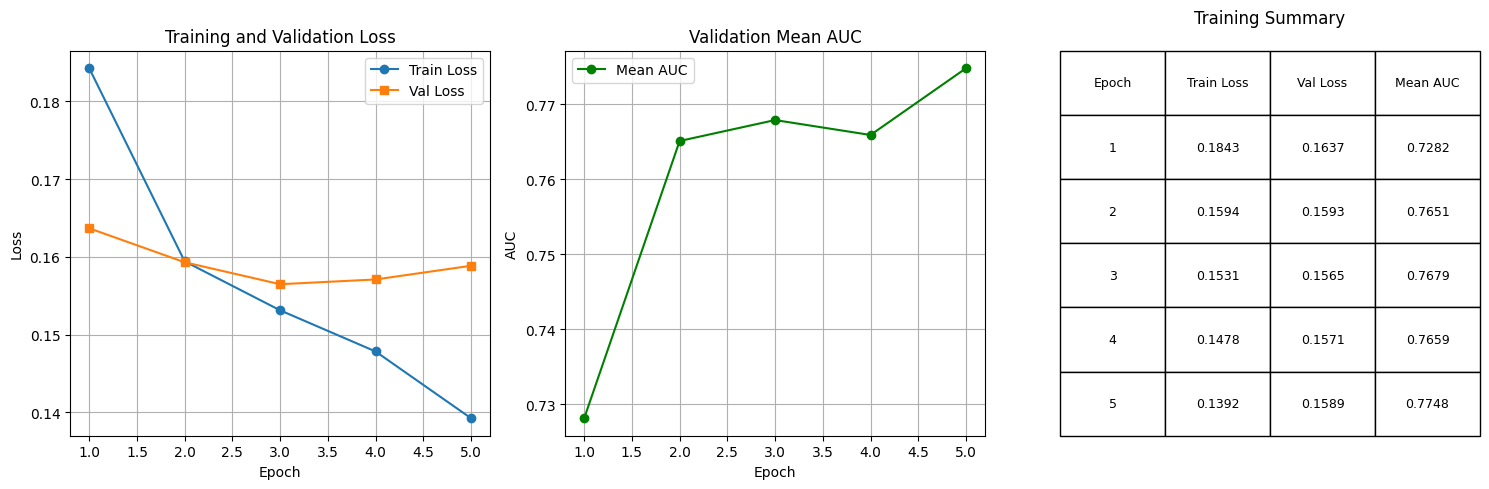

Training curves saved to 'training_curves.png'

FINAL RESULTS SUMMARY

Best Validation AUC: 0.7748 (Epoch 5)
Final Validation AUC: 0.7748
Final Train Loss: 0.1392
Final Val Loss: 0.1589

Baseline model training complete!
Next steps: Implement bias mitigation techniques


In [ ]:
# Save Model
# Save the trained model
MODEL_SAVE_PATH = "densenet121_baseline.pth"
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_aucs': val_aucs,
}, MODEL_SAVE_PATH)

print(f"Model saved to {MODEL_SAVE_PATH}")

# Plot Training Curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, marker='s', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# AUC curve
plt.subplot(1, 3, 2)
plt.plot(range(1, NUM_EPOCHS+1), val_aucs, marker='o', color='green', label='Mean AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation Mean AUC')
plt.legend()
plt.grid(True)

# Summary table
plt.subplot(1, 3, 3)
plt.axis('off')
summary_data = []
for i in range(NUM_EPOCHS):
    summary_data.append([i+1, f"{train_losses[i]:.4f}", f"{val_losses[i]:.4f}", f"{val_aucs[i]:.4f}"])

table = plt.table(cellText=summary_data,
                  colLabels=['Epoch', 'Train Loss', 'Val Loss', 'Mean AUC'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
plt.title('Training Summary', pad=20)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training curves saved to 'training_curves.png'")

# Final Results Summary
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\nBest Validation AUC: {max(val_aucs):.4f} (Epoch {val_aucs.index(max(val_aucs))+1})")
print(f"Final Validation AUC: {val_aucs[-1]:.4f}")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")

print("\n" + "="*60)
print("Baseline model training complete!")
print("Next steps: Implement bias mitigation techniques")
print("="*60)

In [4]:
# ----------------------------
# Reweighted Loss: compute pos_weight for each disease
# ----------------------------
pos_freq_rw = train_df[DISEASE_CATEGORIES].sum().values / len(train_df)
neg_freq_rw = 1 - pos_freq_rw
pos_weight_rw = torch.tensor(neg_freq_rw / (pos_freq_rw + 1e-6), dtype=torch.float32).to(device)

print("Per-disease pos_weight for reweighted loss:")
for disease, w in zip(DISEASE_CATEGORIES, pos_weight_rw):
    print(f"{disease:25s}: {w:.3f}")


NameError: name 'train_df' is not defined

In [ ]:
# ----------------------------
# Reweighted DenseNet-121 Model
# ----------------------------
model_rw = DenseNet121(num_classes=len(DISEASE_CATEGORIES), pretrained=True)
model_rw = model_rw.to(device)

# Loss, optimizer, scheduler
criterion_rw = nn.BCEWithLogitsLoss(pos_weight=pos_weight_rw)
optimizer_rw = optim.Adam(model_rw.parameters(), lr=1e-4)
scheduler_rw = optim.lr_scheduler.ReduceLROnPlateau(optimizer_rw, mode='min', factor=0.5, patience=2)

print("Reweighted DenseNet-121 model initialized!")


In [ ]:

train_losses_rw = []
val_losses_rw = []
val_aucs_rw = []


In [ ]:
NUM_EPOCHS_RW = 5  # can adjust
print(f"Starting Reweighted Training - {NUM_EPOCHS_RW} epochs")

for epoch in range(NUM_EPOCHS_RW):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_RW}")
    
    train_loss = train_epoch(model_rw, train_loader, criterion_rw, optimizer_rw, device)
    val_loss, mean_auc, auc_scores = validate_epoch(model_rw, val_loader, criterion_rw, device)
    
    train_losses_rw.append(train_loss)
    val_losses_rw.append(val_loss)
    val_aucs_rw.append(mean_auc)
    
    scheduler_rw.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Mean AUC: {mean_auc:.4f}")


In [ ]:
MODEL_SAVE_PATH_RW = "densenet121_reweighted.pth"
torch.save({
    'epoch': NUM_EPOCHS_RW,
    'model_state_dict': model_rw.state_dict(),
    'optimizer_state_dict': optimizer_rw.state_dict(),
    'train_losses': train_losses_rw,
    'val_losses': val_losses_rw,
    'val_aucs': val_aucs_rw,
}, MODEL_SAVE_PATH_RW)

print(f"Reweighted DenseNet-121 model saved to {MODEL_SAVE_PATH_RW}")


In [ ]:
# Simple comparison of metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss curves
plt.subplot(1,2,1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Baseline Train')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label='Baseline Val')
plt.plot(range(1, NUM_EPOCHS_RW+1), train_losses_rw, '--', label='Reweighted Train')
plt.plot(range(1, NUM_EPOCHS_RW+1), val_losses_rw, '--', label='Reweighted Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

# AUC curves
plt.subplot(1,2,2)
plt.plot(range(1, NUM_EPOCHS+1), val_aucs, label='Baseline Mean AUC')
plt.plot(range(1, NUM_EPOCHS_RW+1), val_aucs_rw, '--', label='Reweighted Mean AUC')
plt.xlabel('Epoch')
plt.ylabel('Mean AUC')
plt.title('Validation Mean AUC Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
